In [1]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the Oxford dataset
mat = scipy.io.loadmat(r"F:\Project\Oxford_Battery_Degradation_Dataset_1.mat")

In [3]:
# Print the names of the variables in the MAT file
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'])


In [4]:
# Assuming mat is your loaded data
for cell_id in range(1, 9):  # Assuming you have 8 cells
    cell_name = "Cell{}".format(cell_id)
    cell_data = mat[cell_name][0, 0]

    print(f"{cell_name} (struct)")

    for cycle_name in cell_data.dtype.names:
        if cycle_name.startswith('cyc'):
            print(f"{cycle_name} (field)")

            for field_name in ['C1ch', 'C1dc', 'OCVch', 'OCVdc']:
                try:
                    field_data = cell_data[cycle_name][0, 0][field_name][0, 0]
                    print(f"{field_name} (field)")

                    # Get the names of files inside the field
                    file_names = field_data.dtype.names
                    for file_name in file_names:
                        print(f"{file_name} (field)")
                except KeyError:
                    pass  # Handle the case where the field may not exist for a particular cycle

Cell1 (struct)
cyc0000 (field)
C1ch (field)
t (field)
v (field)
q (field)
T (field)
C1dc (field)
t (field)
v (field)
q (field)
T (field)
OCVch (field)
t (field)
v (field)
q (field)
T (field)
OCVdc (field)
t (field)
v (field)
q (field)
T (field)
cyc0100 (field)
C1ch (field)
t (field)
v (field)
q (field)
T (field)
C1dc (field)
t (field)
v (field)
q (field)
T (field)
OCVch (field)
t (field)
v (field)
q (field)
T (field)
OCVdc (field)
t (field)
v (field)
q (field)
T (field)
cyc0200 (field)
C1ch (field)
t (field)
v (field)
q (field)
T (field)
C1dc (field)
t (field)
v (field)
q (field)
T (field)
OCVch (field)
t (field)
v (field)
q (field)
T (field)
OCVdc (field)
t (field)
v (field)
q (field)
T (field)
cyc0300 (field)
C1ch (field)
t (field)
v (field)
q (field)
T (field)
C1dc (field)
t (field)
v (field)
q (field)
T (field)
OCVch (field)
t (field)
v (field)
q (field)
T (field)
OCVdc (field)
t (field)
v (field)
q (field)
T (field)
cyc0400 (field)
C1ch (field)
t (field)
v (field)
q (field)
T (fie

In [5]:
# Extract and preprocess data for C1dc
input_data = []
CELL_SIZES = [83, 78, 82, 52, 51, 51, 82, 82]

for i, cell_size in enumerate(CELL_SIZES):
    cell_num = "Cell{}".format(i + 1)
    for j in range(int(cell_size)):
        cyc_num = "cyc{:04d}".format(j * 100)
        
        try:
            curr = mat[cell_num][0][cyc_num][0][0]["C1dc"][0][0]['q'][0][-1][0]
        except ValueError:
            curr = np.nan  # Set curr to NaN if value retrieval fails
        
        input_data.append([i + 1, j, curr])

# Create a DataFrame from the input data
df_input_dc = pd.DataFrame(input_data, columns=['cell', 'cycle', 'q_value_dc'])

In [6]:
# Increment cycle values by 100
df_input_dc['cycle'] = df_input_dc['cycle'] * 100

In [7]:
print(df_input_dc)

     cell  cycle  q_value_dc
0       1      0 -739.110921
1       1    100 -730.192949
2       1    200 -725.746738
3       1    300 -722.843197
4       1    400 -718.366896
..    ...    ...         ...
556     8   7700 -562.967109
557     8   7800 -562.600497
558     8   7900 -561.111148
559     8   8000 -558.161084
560     8   8100 -558.958140

[561 rows x 3 columns]


In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_input_dc)

     cell  cycle  q_value_dc
0       1      0 -739.110921
1       1    100 -730.192949
2       1    200 -725.746738
3       1    300 -722.843197
4       1    400 -718.366896
5       1    500 -714.978701
6       1    600 -711.620405
7       1    700 -709.532117
8       1    800 -705.848011
9       1    900 -702.544977
10      1   1000 -699.415648
11      1   1100 -696.283591
12      1   1200 -693.267285
13      1   1300 -690.368794
14      1   1400 -687.619241
15      1   1500         NaN
16      1   1600 -681.826315
17      1   1700         NaN
18      1   1800 -675.887127
19      1   1900 -672.743286
20      1   2000 -669.731798
21      1   2100 -667.418483
22      1   2200 -663.952620
23      1   2300 -661.439609
24      1   2400 -658.232450
25      1   2500 -656.301966
26      1   2600 -652.781045
27      1   2700 -651.274270
28      1   2800 -648.850103
29      1   2900 -645.021840
30      1   3000 -644.168985
31      1   3100 -642.089160
32      1   3200 -638.772923
33      1   33

In [9]:
# Linear interpolation for q_value_dc with missing values handled
df_input_dc['q_value_dc'] = df_input_dc.groupby('cell')['q_value_dc'].transform(lambda x: x.interpolate(method='linear', limit_area='inside'))

# Calculate state of health (soh_dc)
df_input_dc['soh_dc'] = df_input_dc['q_value_dc'] / 740

In [10]:
df_input_dc = abs(df_input_dc)

In [11]:
df_input_dc['Degradation'] = ((740 - df_input_dc['q_value_dc'] )/ 740)*100
df_input_dc['Battery_Health'] = 100 - df_input_dc['Degradation']

In [12]:
print(df_input_dc)

     cell  cycle  q_value_dc    soh_dc  Degradation  Battery_Health
0       1      0  739.110921  0.998799     0.120146       99.879854
1       1    100  730.192949  0.986747     1.325277       98.674723
2       1    200  725.746738  0.980739     1.926117       98.073883
3       1    300  722.843197  0.976815     2.318487       97.681513
4       1    400  718.366896  0.970766     2.923392       97.076608
..    ...    ...         ...       ...          ...             ...
556     8   7700  562.967109  0.760766    23.923364       76.076636
557     8   7800  562.600497  0.760271    23.972906       76.027094
558     8   7900  561.111148  0.758258    24.174169       75.825831
559     8   8000  558.161084  0.754272    24.572827       75.427173
560     8   8100  558.958140  0.755349    24.465116       75.534884

[561 rows x 6 columns]


In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_input_dc)

     cell  cycle  q_value_dc    soh_dc  Degradation  Battery_Health
0       1      0  739.110921  0.998799     0.120146       99.879854
1       1    100  730.192949  0.986747     1.325277       98.674723
2       1    200  725.746738  0.980739     1.926117       98.073883
3       1    300  722.843197  0.976815     2.318487       97.681513
4       1    400  718.366896  0.970766     2.923392       97.076608
5       1    500  714.978701  0.966187     3.381257       96.618743
6       1    600  711.620405  0.961649     3.835080       96.164920
7       1    700  709.532117  0.958827     4.117281       95.882719
8       1    800  705.848011  0.953849     4.615134       95.384866
9       1    900  702.544977  0.949385     5.061490       94.938510
10      1   1000  699.415648  0.945156     5.484372       94.515628
11      1   1100  696.283591  0.940924     5.907623       94.092377
12      1   1200  693.267285  0.936848     6.315232       93.684768
13      1   1300  690.368794  0.932931     6.706

In [14]:
# Define the list of cells you want to include
selected_cells = [1, 2, 3, 4, 5, 6, 7, 8]

# Define the cycle values of interest
cycle_values_of_interest = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]

# Initialize an empty list to store the extracted values
extracted_values = []

# Extract values for each cell and cycle value
for cell_num in selected_cells:
    for cycle_value in cycle_values_of_interest:
        # Filter the DataFrame for the selected cell and cycle value
        filtered_data = df_input_dc[(df_input_dc['cell'] == cell_num) & (df_input_dc['cycle'] == cycle_value)]
        
        # If there's data for the given cell and cycle value, extract the values
        if not filtered_data.empty:
            # Extract the desired values, for example 'q_value_ch'
            extracted_value = filtered_data['q_value_dc'].iloc[0]  # Assuming q_value_ch is the column of interest
            
            # Append the extracted value along with cell and cycle information to the list
            extracted_values.append({'cell': cell_num, 'cycle': cycle_value, 'q_value_dc': extracted_value})

# Create a new DataFrame from the extracted values
new_df = pd.DataFrame(extracted_values)

# Display the new DataFrame
print(new_df)

    cell  cycle  q_value_dc
0      1      0  739.110921
1      1   1000  699.415648
2      1   2000  669.731798
3      1   3000  644.168985
4      1   4000  623.553165
..   ...    ...         ...
57     8   4000  629.140496
58     8   5000  607.326272
59     8   6000  588.582376
60     8   7000  573.021086
61     8   8000  558.161084

[62 rows x 3 columns]


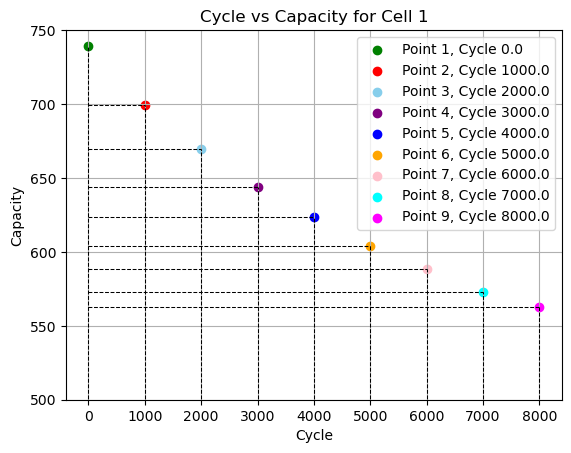

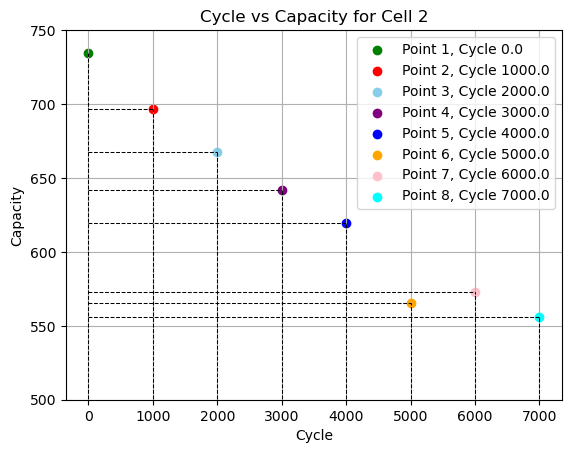

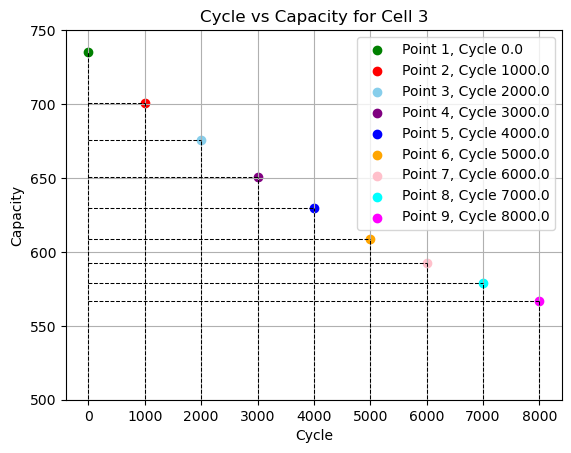

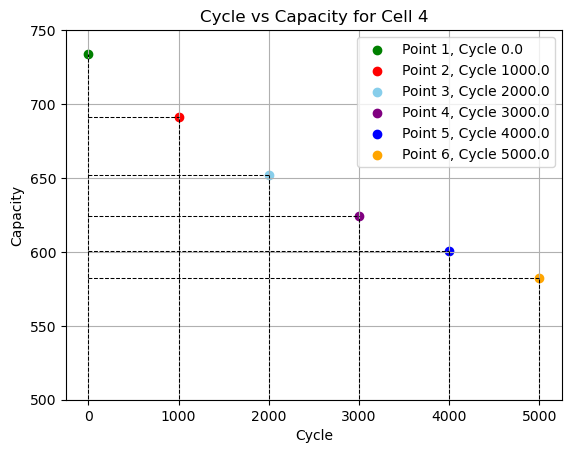

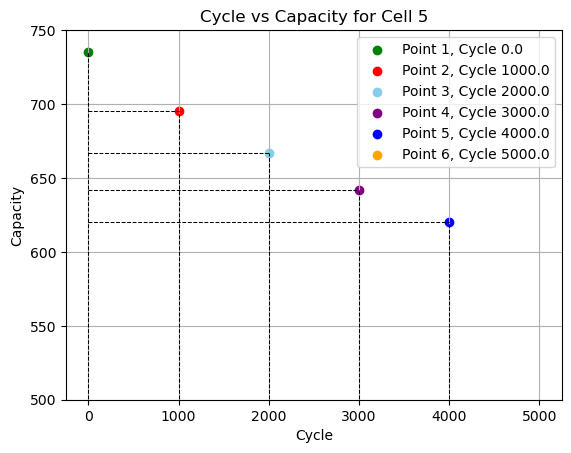

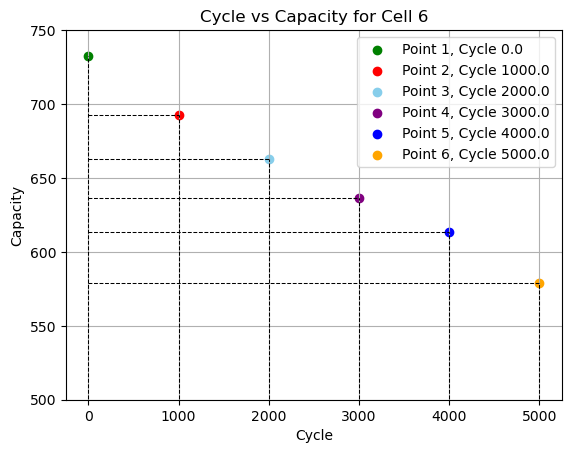

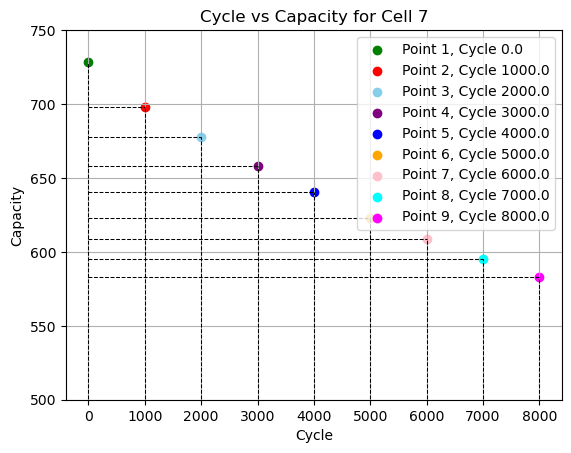

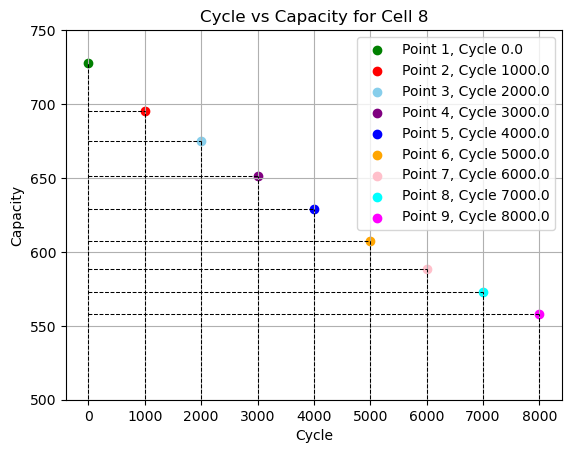

In [15]:
import matplotlib.pyplot as plt

# Define the list of cells you want to include
selected_cells = [1, 2, 3, 4, 5, 6, 7, 8]

# Define the colors for the nine points
colors = ['green', 'red', 'skyblue', 'purple', 'blue', 'orange', 'pink', 'cyan', 'magenta']

# Plotting scatter plot for each selected cell
for cell_num in selected_cells:
    # Filter the DataFrame for the selected cell and get the first five points
    cell_data = new_df[new_df['cell'] == cell_num]
    
    # Create a new plot for each cell
    plt.figure()
    for i, (_, row) in enumerate(cell_data.iterrows()):
        plt.scatter(row['cycle'], row['q_value_dc'], color=colors[i], label=f'Point {i+1}, Cycle {row["cycle"]}')
        plt.plot([row['cycle'], row['cycle']], [0, row['q_value_dc']], color='black', linestyle='--', linewidth=0.75)
        plt.plot([0, row['cycle']], [row['q_value_dc'], row['q_value_dc']], color='black', linestyle='--', linewidth=0.75)

    plt.xlabel('Cycle')
    plt.ylabel('Capacity')
    # Set y-axis limits
    plt.ylim(500,750)
    plt.title(f'Cycle vs Capacity for Cell {cell_num}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
# IMPORTING THE NECESSARY PACKAGES

In [17]:
from tensorflow.keras.layers import Bidirectional, GRU, Dense
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import seaborn as sns

In [18]:
# USING THE MAPE ERROR calculation FORMULA GIVE IN THE BASE PAPER
def calculate_mape(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    
    n = len(y_true)  # Number of data points
    mape_sum = 0.0
    
    for i in range(n):
        mape_sum += abs((y_pred[i] - y_true[i]) / y_true[i])
    
    mape = (100 / n) * mape_sum
    
    return mape.item()  # Convert the numpy array to a scalar and return

In [19]:
# Separate data for training and testing
train_cells = [1, 2, 3, 4, 5, 6]
test_cells = [7, 8]

In [20]:
# Initialize lists to store training and testing data
X_train_all = []
y_train_all = []
X_test_all = []
y_test_all = []

In [21]:
# Extract data for training set
for cell_id in train_cells:
    df_cell = df_input_dc[df_input_dc['cell'] == cell_id]
    X_train_cell = df_cell[['cycle', 'q_value_dc', 'Degradation']].values
    y_train_cell = df_cell['Battery_Health'].values
    X_train_all.append(X_train_cell)
    y_train_all.append(y_train_cell)

In [22]:
# Extract data for testing set
for cell_id in test_cells:
    df_cell = df_input_dc[df_input_dc['cell'] == cell_id]
    X_test_cell = df_cell[['cycle', 'q_value_dc', 'Degradation']].values
    y_test_cell = df_cell['Battery_Health'].values
    X_test_all.append(X_test_cell)
    y_test_all.append(y_test_cell)

In [23]:
# Concatenate data from all cells
X_train = np.concatenate(X_train_all, axis=0)
y_train = np.concatenate(y_train_all, axis=0)
X_test = np.concatenate(X_test_all, axis=0)
y_test = np.concatenate(y_test_all, axis=0)

In [24]:
# Reshape X to fit in the GRU
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

In [25]:
# Building the model
model = Sequential()
model.add(Bidirectional(GRU(512, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(GRU(256, return_sequences=False)))
model.add(Dense(128, activation='relu')) 
model.add(Dense(1, activation='linear'))
model.compile(optimizer='Adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=52, verbose=1, validation_data=(X_test, y_test))

Epoch 1/500
8/8 [==============================] - 23s 730ms/step - loss: 5138.5625 - mae: 70.8603 - val_loss: 3042.6375 - val_mae: 54.8137
Epoch 2/500
8/8 [==============================] - 2s 227ms/step - loss: 2108.7285 - mae: 44.8451 - val_loss: 957.3504 - val_mae: 30.3311
Epoch 3/500
8/8 [==============================] - 2s 211ms/step - loss: 481.6548 - mae: 19.7770 - val_loss: 67.2327 - val_mae: 6.5154
Epoch 4/500
8/8 [==============================] - 2s 253ms/step - loss: 72.0004 - mae: 6.9694 - val_loss: 133.8975 - val_mae: 9.9423
Epoch 5/500
8/8 [==============================] - 2s 261ms/step - loss: 162.0255 - mae: 10.9288 - val_loss: 124.3040 - val_mae: 9.5002
Epoch 6/500
8/8 [==============================] - 2s 300ms/step - loss: 89.2617 - mae: 7.8245 - val_loss: 40.2125 - val_mae: 5.4890
Epoch 7/500
8/8 [==============================] - 2s 232ms/step - loss: 48.3903 - mae: 5.8239 - val_loss: 47.1002 - val_mae: 5.6077
Epoch 8/500
8/8 [==============================] - 

In [26]:
# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)

# Compute metrics
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE for Test Set: {rmse}")
print(f"R2 score for Test Set: {r2}")
print(f"MAPE for Test Set: {mape}")
print(f"MAE for Test Set: {mae}")

6/6 [==============================] - 2s 9ms/step
RMSE for Test Set: 0.09758695576041655
R2 score for Test Set: 0.9997467625133389
MAPE for Test Set: 0.09638259559869766
MAE for Test Set: 0.08239799003384622


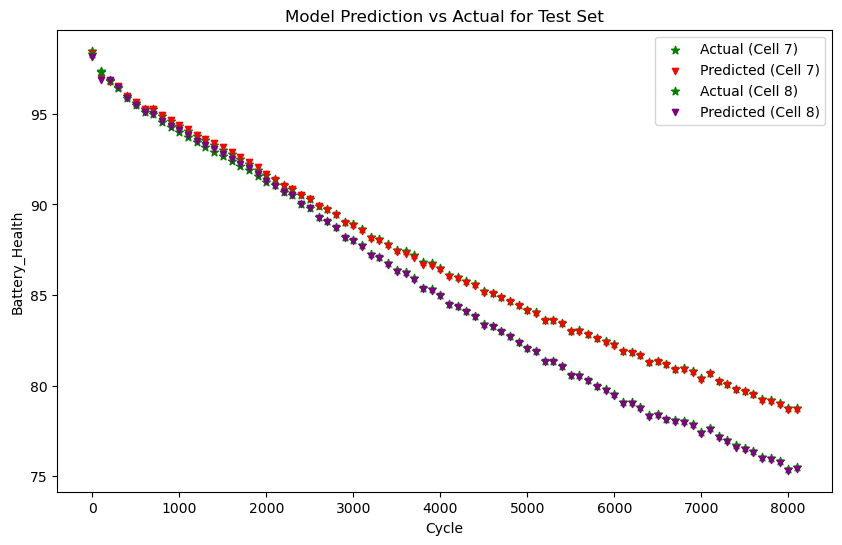

In [27]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:len(y_test_all[0]), 0], y_test_all[0], label='Actual (Cell 7)', color='green', marker='*', s=35)
plt.scatter(X_test[:len(y_test_all[0]), 0], y_pred[:len(y_test_all[0])], label='Predicted (Cell 7)', color='red', marker='v', s=20)
plt.scatter(X_test[len(y_test_all[0]):, 0], y_test_all[1], label='Actual (Cell 8)', color='green', marker='*', s=35)
plt.scatter(X_test[len(y_test_all[0]):, 0], y_pred[len(y_test_all[0]):], label='Predicted (Cell 8)', color='purple', marker='v', s=20)
plt.xlabel('Cycle')
plt.ylabel('Battery_Health')
plt.title('Model Prediction vs Actual for Test Set')
plt.legend()
plt.show()

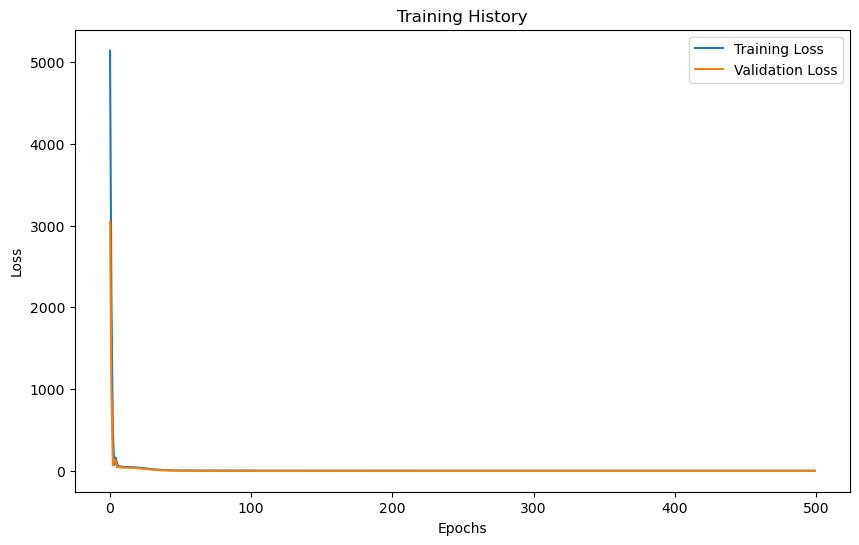

In [28]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.show()